Paper I followed: https://sci-hub.se/https://dl.acm.org/doi/10.1145/3309129.3309141

# Import Libraries

In [1]:
import numpy as np
import cv2
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

# Read Image

In [2]:
# Sample Images to test
# ISIC_0074311 (Without Hair)
# ISIC_0086632 (With Hair)

In [3]:
image = cv2.imread("dataset/jpeg/train/ISIC_0075663.jpg")

In [4]:
image.shape

(1936, 2592, 3)

# Visualization functions

In [5]:
def fixColor(image):
    return(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

In [6]:
def print_contour(con):
    rescale2=rescale.copy()
    cv2.drawContours(rescale2,con,-1, (0, 0, 255), 3)
    plt.imshow(fixColor(rescale2))
#     cv2.imshow('Image',rescale2)
#     cv2.waitKey(0) 
#     cv2.destroyAllWindows()

# Rescale

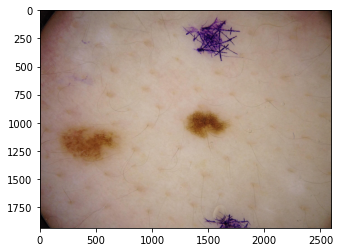

In [7]:
scale_percent = 10
width = int(image.shape[1] * scale_percent / 100)
height = int(image.shape[0] * scale_percent / 100)
dim = (width, height)
rescale = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
plt.imshow(fixColor(image))

# Gaussian Blur

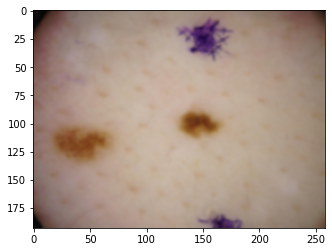

In [8]:
blur = cv2.GaussianBlur(rescale, (5, 5), 0)
plt.imshow(fixColor(blur))

# Contrast Change

In [9]:
# Automatic brightness and contrast optimization with optional histogram clipping
def automatic_brightness_and_contrast(image, clip_hist_percent=1):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Calculate grayscale histogram
    hist = cv2.calcHist([gray],[0],None,[256],[0,256])
    hist_size = len(hist)

    # Calculate cumulative distribution from the histogram
    accumulator = []
    accumulator.append(float(hist[0]))
    for index in range(1, hist_size):
        accumulator.append(accumulator[index -1] + float(hist[index]))

    # Locate points to clip
    maximum = accumulator[-1]
    clip_hist_percent *= (maximum/100.0)
    clip_hist_percent /= 2.0

    # Locate left cut
    minimum_gray = 0
    while accumulator[minimum_gray] < clip_hist_percent:
        minimum_gray += 1

    # Locate right cut
    maximum_gray = hist_size -1
    while accumulator[maximum_gray] >= (maximum - clip_hist_percent):
        maximum_gray -= 1

    # Calculate alpha and beta values
    alpha = 255 / (maximum_gray - minimum_gray)
    beta = -minimum_gray * alpha

    '''
    # Calculate new histogram with desired range and show histogram 
    new_hist = cv2.calcHist([gray],[0],None,[256],[minimum_gray,maximum_gray])
    plt.plot(hist)
    plt.plot(new_hist)
    plt.xlim([0,256])
    plt.show()
    '''

    auto_result = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    return (auto_result, alpha, beta)

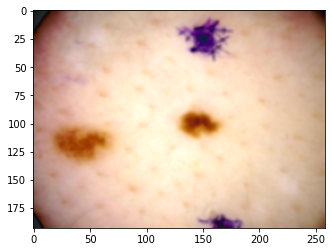

In [10]:
contrast, alpha, beta = automatic_brightness_and_contrast(blur)
plt.imshow(fixColor(contrast))

# Grayscale

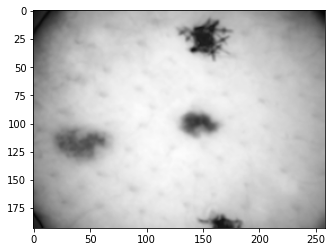

In [11]:
gray = cv2.cvtColor(contrast, cv2.COLOR_BGR2GRAY)
plt.imshow(fixColor(gray))

# Dilation

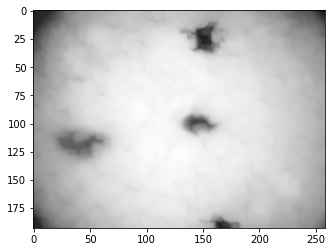

In [12]:
kernel=np.ones((5,5),np.uint8)
dilate = cv2.dilate(gray,kernel,iterations = 1)
plt.imshow(fixColor(dilate))

# Otsu Thresholding

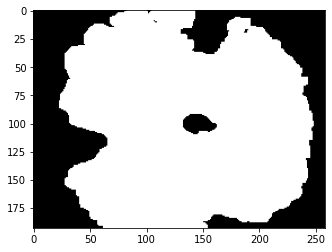

In [13]:
ret, thresh = cv2.threshold(dilate,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
plt.imshow(fixColor(thresh))

# Canny Edge Detection

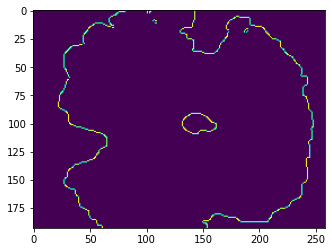

In [14]:
canny = cv2.Canny(thresh, 50, 50)
plt.imshow(canny)

# Contour Detection
Contours can be explained simply as a curve joining all the continuous points (along the boundary), having same color or intensity. The contours are a useful tool for shape analysis and object detection and recognition.

In [15]:
#(contours, _) = cv2.findContours(canny, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

In [16]:
(contours, _) = cv2.findContours(canny, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

In [17]:
print('No. of contours found in image: ',len(contours))

No. of contours found in image:  13


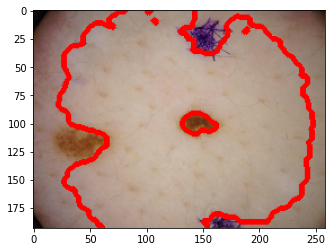

In [18]:
print_contour(contours)

# Segmentation

### Method 1 - Thresholding of no. of coordinates

In [19]:
def fun1(top):
    d={}
    c=0

    for i in contours:
        d[c]=len(i)
        c=c+1

    d = dict(sorted(d.items(), key=lambda item: item[1],reverse=True))
    k = list(d.keys())[:top]
    final = [contours[i] for i in k]
    return final

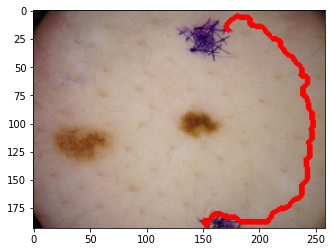

In [20]:
# get contour with highest no. of coordinates
print_contour(fun1(1))

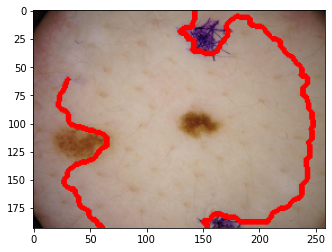

In [21]:
# get 3 contour with highest no. of coordinates
print_contour(fun1(3))

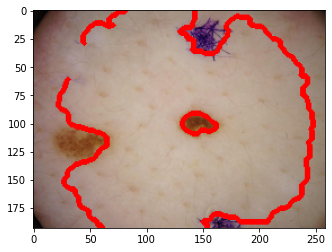

In [35]:
# get 5 contour with highest no. of coordinates
print_contour(fun1(5))

### Method 2 - Thresholding of area

In [22]:
# getting contour with highest area
temp = 0
for contour in contours:
    area = cv2.contourArea(contour)
    if(area>temp):
        temp=area

area:  383.5
**************************************************


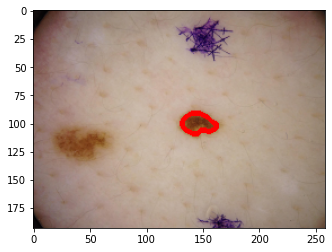

In [23]:
contour_list = []
for contour in contours:   
    area = cv2.contourArea(contour)

    if(area>=temp):
        print('area: ',area)
        print('*'*50)
        contour_list.append(contour)
        
print_contour(contour_list)

### Method 3 - Thresholding of shape

* https://rsdharra.com/blog/lesson/16.html

perimeter:  82.18376564979553 , shape:  11
**************************************************
perimeter:  701.6711329221725 , shape:  12
**************************************************


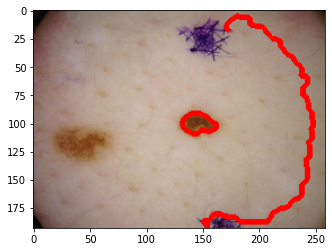

In [32]:
contour_list = []
for contour in contours:
    perimeter = cv2.arcLength(contour,True) # calculate the perimeter of the contour. If the second argument is True then it considers the contour to be closed.
    approx = cv2.approxPolyDP(contour,0.01*perimeter,True) # the shape of the contour is approximated
        
    if(10<len(approx)<13):
        print('perimeter: ',perimeter,', shape: ',len(approx))
        print('*'*50)
        contour_list.append(contour)
        
print_contour(contour_list)

# Bounding Box

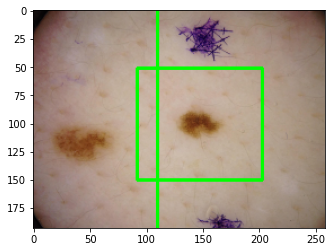

In [33]:
# Draw Bounding box around contour (Crop image)
rescale2=rescale.copy()
for cnt in contour_list:
    x,y,w,h = cv2.boundingRect(cnt)
    x=x-40
    y=y-40
    w=w+80
    h=h+80
    cv2.rectangle(rescale2,(x,y),(x+w,y+h),(0,255,0),2)
plt.imshow(fixColor(rescale2))

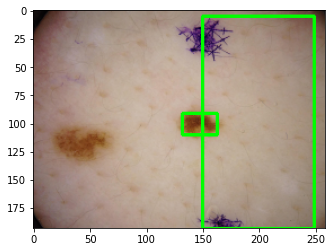

In [34]:
# Draw Bounding box around contour (Find Features)
rescale2=rescale.copy()
for cnt in contour_list:
    x,y,w,h = cv2.boundingRect(cnt)
    cv2.rectangle(rescale2,(x,y),(x+w,y+h),(0,255,0),2)
plt.imshow(fixColor(rescale2))

In [27]:
# diameter
# (x+w)-x
# (y+h)-y
# EucDist[(x+w,y+h), (x,y)]
# EucDist[(x,y+h), (x+w,y)]

# References

* https://github.com/cloudxlab/opencv-intro/blob/master/6_edge_detection.ipynb
* https://www.authentise.com/post/detecting-circular-shapes-using-contours
* https://www.kaggle.com/alexako/cs200-1-u-net-skin-lesion-segmentation
* https://www.geeksforgeeks.org/python-imageops-autocontrastmethod/
* https://github.com/clembac/melanoma_detection/blob/master/notebook.ipynb